# Clusterizacao

[**Premier League Data**](https://www.kaggle.com/thesiff/premierleague1819)

## Carregando bibliotecas

In [467]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from subprocess import call
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
import sklearn as sk 
from numpy import random
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import os
pd.options.display.max_rows = 2000
%matplotlib inline

In [468]:
df_epl = pd.read_csv(os.path.join(os.path.abspath(''), "data/epl_1819.csv"))
df_transfer = pd.read_csv(os.path.join(os.path.abspath(''), "data/transfer.csv"))

df = df_epl.join(df_transfer)

# Drop de team por ficar duplicado apos o join
df.drop(columns="team", inplace=True)

df.head(1)

,Team,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,...,end_2018,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total
0,Manchester City,Champions League,1,26,150986355,38,32,2,4,95,...,-226.15,-178.15,-140.86,-57.68,-104.7,-17.65,-59.85,-146.46,-116.35,-1070.83


# Identificando dados faltando

In [469]:
missing = df.isna().mean().gt(0)
missing[missing == True]

Series([], dtype: bool)

Nenhuma coluna possui dados faltando

# Identificando atributos categoricos

In [470]:
obj_attrs = df.select_dtypes("object").columns.values
df[obj_attrs].head(3)

,Team,category,attack_passes,attack_passes_long,attack_passes_back,defence_clearances
0,Manchester City,Champions League,"26,581","1,814","4,240",543
1,Liverpool,Champions League,"23,638","2,250","3,416",639
2,Chelsea,Champions League Qualification,"25,070","1,774","3,874",593


Os atributos `attack_passes`, `attack_passes_long`, `attack_passes_back` e `defence_clearances` são numericos mas foram entendidos como object porque utilizam de virgula para separador de milhar. 

Podemos entao converter esses atributos para formato numerico

In [471]:
transform_attrs = [attr for attr in obj_attrs if attr != "category" and attr != "Team"]
df[transform_attrs] = df[transform_attrs].apply(lambda x: x.str.replace(",", "").astype(int), axis=0)

In [472]:
df[transform_attrs].head(2)

,attack_passes,attack_passes_long,attack_passes_back,defence_clearances
0,26581,1814,4240,543
1,23638,2250,3416,639


O atributos `category` é categorico cardinal e deve ser transformado atravez de algo como one-hot-encoding.

O atributo `Team` pode ser usado como indice.

In [473]:
df = pd.get_dummies(df, columns=["category"]).set_index("Team")
df.head(5)

,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,general_goal_difference,...,end_2012,end_2011,end_2010,Total,category_Champions League,category_Champions League Qualification,category_Europa League,category_Europa League Qualification,category_No UEFA Competitions,category_Relegated
Team,,,,,,,,,,,,,,,,,,,,,
Manchester City,1,26,150986355,38,32,2,4,95,23,72,...,-59.85,-146.46,-116.35,-1070.83,1,0,0,0,0,0
Liverpool,2,29,152425146,38,30,7,1,89,22,67,...,-47.84,-11.99,77.07,-666.55,1,0,0,0,0,0
Chelsea,3,25,146030216,38,21,9,8,63,39,24,...,33.80,-23.67,-8.60,-16.78,0,1,0,0,0,0
Tottenham,4,26,145230801,38,23,2,13,67,39,28,...,-43.63,3.98,5.05,-324.86,0,1,0,0,0,0
Arsenal,5,25,142193180,38,21,7,10,73,51,22,...,-64.05,-105.00,-26.20,-560.93,0,0,1,0,0,0


# Normalização dos atributos

In [474]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df_no_team),columns=df.columns.values, index=df.reset_index()["Team"])

In [475]:
df.head(2)

,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,general_goal_difference,...,end_2012,end_2011,end_2010,Total,category_Champions League,category_Champions League Qualification,category_Europa League,category_Europa League Qualification,category_No UEFA Competitions,category_Relegated
Team,,,,,,,,,,,,,,,,,,,,,
Manchester City,-1.647509,1.355819,1.587439,0.0,2.341753,-2.138031,-1.733109,2.350452,-1.992988,2.281980,...,-2.016336,-3.390784,-3.403626,-3.345767,3.0,-0.333333,-0.333333,-0.229416,-1.0,-0.420084
Liverpool,-1.474087,1.812837,1.668472,0.0,2.058762,-0.041922,-2.187198,2.009807,-2.058119,2.123509,...,-1.538152,0.065596,2.296763,-1.719834,3.0,-0.333333,-0.333333,-0.229416,-1.0,-0.420084


# Redução de dimensionalidade 

Utilizaremos PCA ( Principal Component Analysis ) para redução de dimensionalidade 

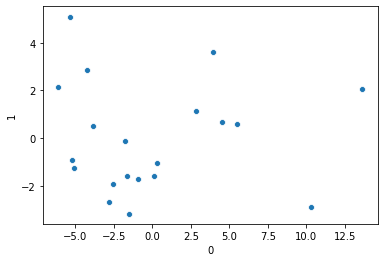

In [476]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pca = PCA(n_components=2)

df_proj = pd.DataFrame(pca.fit_transform(df), index=df.reset_index()["Team"])

sns.scatterplot(x=df_proj[0], y=df_proj[1])

# Clusterização

Será utilizada a metrica silhouette como indicador da qualidade dos agrupamentos

## Metricas para diferentes numeros de cluster

In [732]:
silhouette_values = []
for i in range (2, 20):
    kmeans = KMeans(n_clusters=i).fit(df_proj)
    hierarquico = AgglomerativeClustering(n_clusters=i)


    km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))
    h_clustered = df_proj.assign(cluster_number=hierarquico.fit_predict(df_proj))

  
    silhouette_values.append({
        "n_clusters": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
        "silhouette_h": sk.metrics.silhouette_score(h_clustered, labels=h_clustered["cluster_number"]),
    })


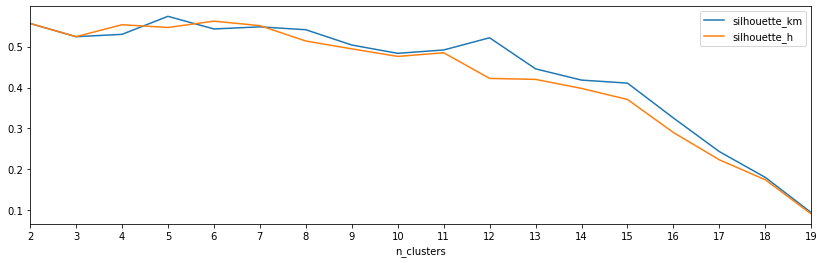

In [733]:
pd.DataFrame(silhouette_values).plot.line(x="n_clusters", 
                                             y=["silhouette_km", "silhouette_h"],
                                             xticks=range(2,20),
                                             figsize=[14,4])

Kmeans atingiu melhor resultado com K=5 e hierarquico com K=6

## Metricas para diferentes valores de max_iterations em K-Means

In [802]:
silhouette_values = []
for i in range (0, 101, 10):
    kmeans = KMeans(n_clusters=5, max_iter=i if i > 0 else 1).fit(df_proj)

    km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))

    silhouette_values.append({
        "max_iter": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
    })

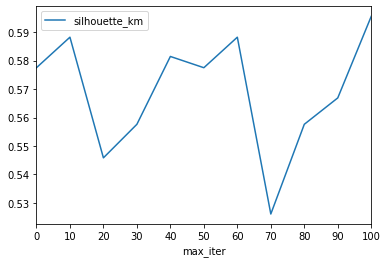

In [803]:
pd.DataFrame(silhouette_values).plot.line(x="max_iter",
                                          y="silhouette_km",
                                          xticks=range(0,101,10))

A melhor metrica foi a associada a max_iter de 100, mas foi percebido que a cada nova amostragem o grafico parecia muito diferente

## KMeans com n_clusters=5 e max_iter=100


In [814]:
kmeans = KMeans(n_clusters=5, max_iter=100).fit(df_proj)

km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))

sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"])

0.5882883149238604

# Metricas para diferentes linkages

In [819]:
silhouette_values = []
for i in ["ward", "complete", "average", "single"]:
    hierarquico = AgglomerativeClustering(n_clusters=5, linkage=i)

    km_clustered = df_proj.assign(cluster_number=hierarquico.fit_predict(df_proj))

    silhouette_values.append({
        "linkage": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
    })

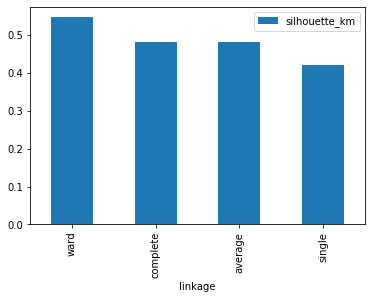

In [820]:
pd.DataFrame(silhouette_values).plot.bar(x="linkage", y="silhouette_km")

A melhor linkage foi `ward`

# Comparando os melhores resultados para os dois algoritmos

Silhouette:  0.5566053306880632


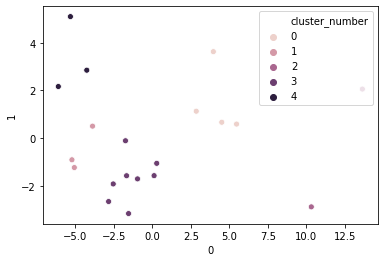

In [859]:
kmeans = KMeans(n_clusters=5, max_iter=100).fit(df_proj)

km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))

sns.scatterplot(x=km_clustered[0], y=km_clustered[1], hue=km_clustered["cluster_number"], legend="full")
print("Silhouette: ", sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]))

Silhouette:  0.5623364818261255


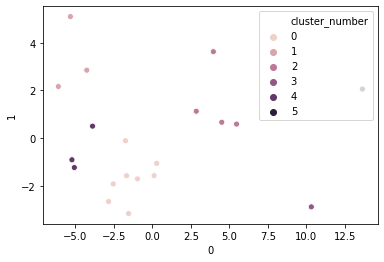

In [858]:
hierarquico = AgglomerativeClustering(n_clusters=6, linkage="ward")
h_clustered =  df_proj.assign(cluster_number=hierarquico.fit_predict(df_proj))
sns.scatterplot(x=h_clustered[0], y=h_clustered[1], hue=h_clustered["cluster_number"], legend="full")
print("Silhouette: ", sk.metrics.silhouette_score(h_clustered, labels=h_clustered["cluster_number"]))

In [860]:
pd.DataFrame([sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
sk.metrics.silhouette_score(h_clustered, 
                            labels=h_clustered["cluster_number"])],
                            index=["K-Means", "Hierarquico"],
                            columns=["silhouette"])

,silhouette
K-Means,0.556605
Hierarquico,0.562336


## Analisando os grupos

In [874]:
df.assign(cluster_number= h_clustered["cluster_number"]).groupby("cluster_number").var()

,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,general_goal_difference,...,end_2012,end_2011,end_2010,Total,category_Champions League,category_Champions League Qualification,category_Europa League,category_Europa League Qualification,category_No UEFA Competitions,category_Relegated
cluster_number,,,,,,,,,,,,,,,,,,,,,
0,0.180451,0.271442,0.160296,0.0,0.032892,0.238514,0.078551,0.060725,0.288984,0.045634,...,0.187910,0.082263,0.107669,0.051719,0.0,0.000000,0.000000,2.631579,0.5,0.0
1,0.030075,0.054150,0.034565,0.0,0.246926,0.410076,0.091643,0.154719,0.154125,0.092751,...,0.044792,0.048029,0.067627,0.016700,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.050125,0.021273,0.011750,0.0,0.053389,1.918571,0.097371,0.060168,0.264062,0.053156,...,3.371712,1.544553,0.593971,0.804368,0.0,3.703704,3.703704,0.000000,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.030075,0.054150,0.007324,0.0,0.026695,1.113064,0.068732,0.107444,0.069285,0.006362,...,0.066613,0.001708,0.003577,0.058038,0.0,0.000000,0.000000,0.000000,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
